In [2]:
# Import PyTorch
import torch
from torch import nn

# Import torchvision 
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

# Import matplotlib for visualization
import matplotlib.pyplot as plt

# Check versions
# Note: your PyTorch version shouldn't be lower than 1.10.0 and torchvision version shouldn't be lower than 0.11
print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")

PyTorch version: 2.10.0.dev20251212+rocm7.0
torchvision version: 0.25.0.dev20251213+rocm7.0


In [3]:
# Setup training data
train_data = datasets.FashionMNIST(
    root="data", # where to download data to?
    train=True, # get training data
    download=True, # download data if it doesn't exist on disk
    transform=ToTensor(), # images come as PIL format, we want to turn into Torch tensors
    target_transform=None, # you can transform labels as well
    
)

# Setup testing data
test_data = datasets.FashionMNIST(
    root="data",
    train=False, # get test data
    download=True,
    transform=ToTensor()
)

In [4]:
# See classes
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

Random number: 10694


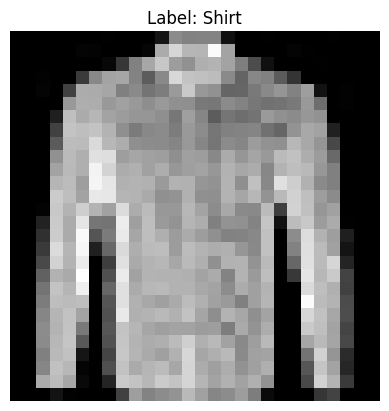

In [22]:
import matplotlib.pyplot as plt
import random

# 1. Grab the raw image tensor
random_number = random.randint(0, len(train_data)-1)
print(f"Random number: {random_number}")
image = train_data.data[random_number]
label = train_data.targets[random_number]
label_name = class_names[label]

# 2. Plot it
plt.imshow(image, cmap="gray") # cmap="gray" forces black & white
plt.title(f"Label: {label_name}")
plt.axis("off") # Optional: Hides the ruler numbers
plt.show()

In [23]:
from torch.utils.data import DataLoader 
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=False)

In [25]:
import torch
from torch import nn

class FashionModel(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), # neural networks like their inputs in vector form
            nn.Linear(in_features=input_shape, out_features=hidden_units), # in_features = number of features in a data sample (784 pixels)
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )
    
    def forward(self, x):
        return self.layer_stack(x)
    
device = "cuda" if torch.cuda.is_available() else "cpu"

fashionModel = FashionModel(
    input_shape=28*28, # 28x28 pixels
    hidden_units=128,
    output_shape=len(class_names) # number of classes
)
fashionModel.to(device)


FashionModel(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=128, bias=True)
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [26]:
import torch.optim as optim

# CrossEntropyLoss is standard for classification (choosing 1 out of N categories)
loss_fn = nn.CrossEntropyLoss()

optimizer = optim.SGD(fashionModel.parameters(), lr=0.01)

In [27]:
epochs = 10

for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    fashionModel.train()
    train_loss, train_acc = 0, 0
    # X is the images y is the labels
    for batch, (X, y) in enumerate(train_dataloader):
        # --- SANITY CHECK (Verifies data is correct) ---
        if epoch == 0 and batch == 0:
            print(f"DEBUG: Data Range is {X.min():.2f} to {X.max():.2f}")
            if X.max() > 1.0:
                print("!! WARNING: Data is not normalized (0-255). Check transforms !!")
        # -----------------------------------------------

        X, y = X.to(device), y.to(device)

        # Forward
        y_pred = fashionModel(X)
        
        # Loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        
        # Accuracy
        train_acc += (y_pred.argmax(1) == y).type(torch.float).sum().item()

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Calculate averages
    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader.dataset) #type: ignore
    
    print(f"Train Loss: {train_loss:.5f} | Train Acc: {train_acc:.2%}")

Epoch 1
-------------------------------
DEBUG: Data Range is 0.00 to 1.00
Train Loss: 0.84760 | Train Acc: 72.60%
Epoch 2
-------------------------------
Train Loss: 0.54860 | Train Acc: 81.38%
Epoch 3
-------------------------------
Train Loss: 0.49448 | Train Acc: 82.92%
Epoch 4
-------------------------------
Train Loss: 0.46920 | Train Acc: 83.68%
Epoch 5
-------------------------------
Train Loss: 0.45329 | Train Acc: 84.32%
Epoch 6
-------------------------------
Train Loss: 0.44260 | Train Acc: 84.79%
Epoch 7
-------------------------------
Train Loss: 0.43502 | Train Acc: 84.98%
Epoch 8
-------------------------------
Train Loss: 0.42910 | Train Acc: 85.17%
Epoch 9
-------------------------------
Train Loss: 0.42385 | Train Acc: 85.45%
Epoch 10
-------------------------------
Train Loss: 0.42058 | Train Acc: 85.42%


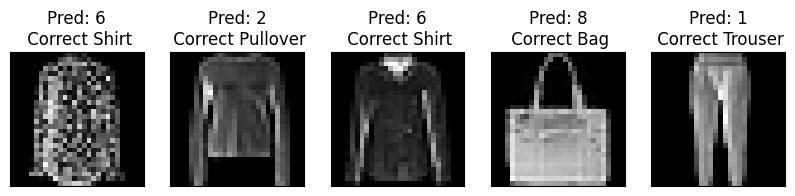

In [34]:
import matplotlib.pyplot as plt

# Get a batch of images
images, labels = next(iter(train_dataloader))

# Get predictions
with torch.no_grad(): # Tell PyTorch we don't need gradients for this (saves memory)
    images = images.to(device)  # Move images to the same device as the model
    outputs = fashionModel(images)
    # The prediction is the index with the highest score
    _, predicted = torch.max(outputs, 1)

# Show the first 5 images and their predictions
fig = plt.figure(figsize=(10, 2))
for i in range(5):
    ax = fig.add_subplot(1, 5, i+1, xticks=[], yticks=[])
    label_name = class_names[labels[i]]
    # Convert tensor image back to numpy for display
    # .cpu() moves it back to system memory
    img = images[i].cpu().squeeze().numpy()
    ax.imshow(img, cmap='gray')
    is_correct = predicted[i].item() == labels[i].item()
    ax.set_title(f"Pred: {predicted[i].item()}\n {'Correct' if is_correct else 'Incorrect'} {label_name}")
plt.show()
